/Users/luwaga/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Device: cpu
Loaded dataset-labeled-anon-ip.csv, shape = (1395324, 47)
Feature count: 42
Balanced df shape: (20000, 43)
Train/Test shapes: (16000, 42), (4000, 42)
Loaded existing model from best_lstm.pt
Ground truth indices: [1, 6, 7, 0, 28]
Evaluating on 500 test samples
\nComputing explanations for all explainers...
\n1. Computing LIME explanations...


LIME: 100%|███████████████████████████████████| 500/500 [01:49<00:00,  4.56it/s]


LIME attributions shape: (500, 42)
\n2. Computing SHAP explanations...


  0%|          | 0/500 [00:00<?, ?it/s]

SHAP attributions shape: (500, 42)
\n3. Computing Integrated Gradients explanations...


IG: 100%|████████████████████████████████████| 500/500 [00:01<00:00, 324.42it/s]


IG attributions shape: (500, 42)
\n4. Computing DeepLIFT explanations...


DeepLIFT: 100%|█████████████████████████████| 500/500 [00:00<00:00, 1152.83it/s]


DeepLIFT attributions shape: (500, 42)
\n============================================================
EVALUATING ALL EXPLAINERS
\nEvaluating LIME...
  Computing faithfulness metrics...
  Computing robustness metrics...
  Computing complexity metrics...
  Computing reliability metrics...
  ✓ LIME complete
\nEvaluating SHAP...
  Computing faithfulness metrics...
  Computing robustness metrics...
  Computing complexity metrics...
  Computing reliability metrics...
  ✓ SHAP complete
\nEvaluating IG...
  Computing faithfulness metrics...
  Computing robustness metrics...
  Computing complexity metrics...
  Computing reliability metrics...
  ✓ IG complete
\nEvaluating DeepLIFT...
  Computing faithfulness metrics...
  Computing robustness metrics...
  Computing complexity metrics...
  Computing reliability metrics...
  ✓ DeepLIFT complete
\n============================================================
RESULTS SAVED TO: xai_comparison_results.csv
\nExplainer  Faithfulness_Corr_Mean  Faithfulnes

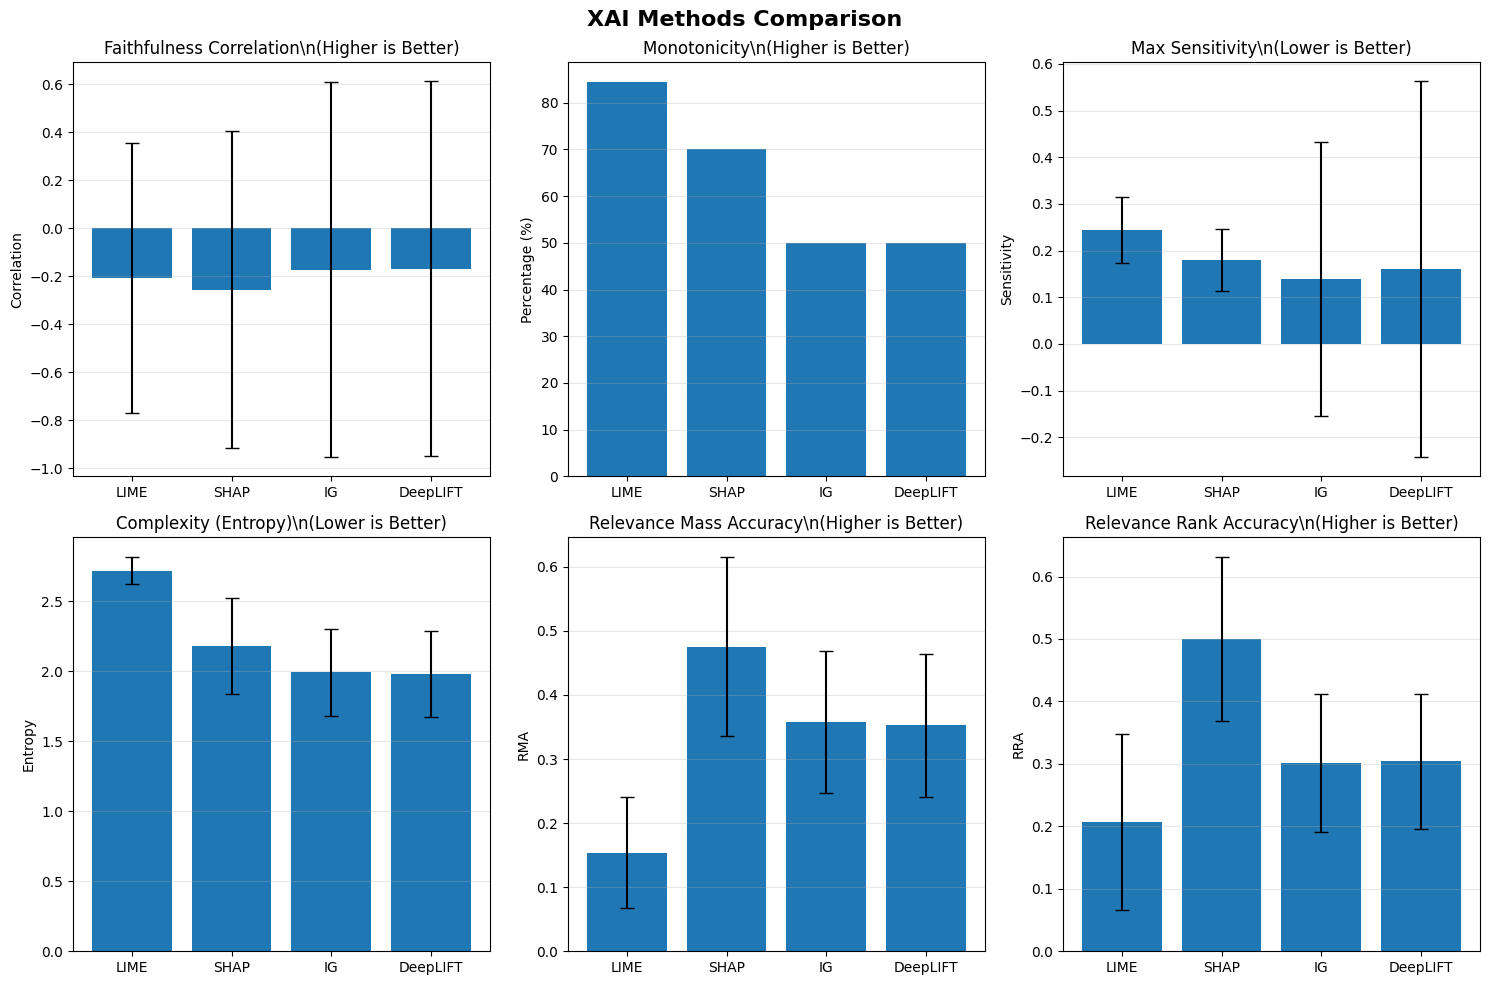

\n============================================================
ANALYSIS COMPLETE!
\nBest performers:
  Faithfulness: DeepLIFT
  Monotonicity: LIME
  Robustness: IG
  Complexity: DeepLIFT
  RMA: SHAP
  RRA: SHAP


In [2]:
import os, random, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib
from scipy.stats import spearmanr
from scipy.spatial.distance import euclidean

warnings.filterwarnings('ignore')

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cpu')  # M1 Mac - use CPU
print(f'Device: {device}')

# ==================== DATA LOADING ====================
DATA_PATH = 'dataset-labeled-anon-ip.csv'
df = pd.read_csv(DATA_PATH)
print(f'Loaded {DATA_PATH}, shape = {df.shape}')

# ==================== PREPROCESSING ====================
label_col = 'Label'
drop_cols = ['SignatureText', 'Timestamp', 'ExtIP', 'IntIP']

for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

df = df.replace({-1: np.nan})
df = df.fillna(0)

feature_cols = [c for c in df.columns if c != label_col]
print(f'Feature count: {len(feature_cols)}')

# Encode categorical features
for c in feature_cols:
    if df[c].dtype == 'object':
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# Balance dataset
n_per_class = 10000
sampled = []
for _, g in df.groupby(label_col):
    sampled.append(g.sample(n=min(n_per_class, len(g)), random_state=seed))
df_bal = pd.concat(sampled).sample(frac=1, random_state=seed).reset_index(drop=True)
print(f'Balanced df shape: {df_bal.shape}')

X = df_bal[feature_cols].values
y = df_bal[label_col].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=seed
)
print(f'Train/Test shapes: {X_train.shape}, {X_test.shape}')

# ==================== DATASET CLASS ====================
class AlertDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

# ==================== LSTM MODEL ====================
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# Load or create model
input_size = X_train.shape[1]
model = LSTMClassifier(input_size=input_size, hidden_size=128, num_layers=2, dropout=0.2)

if Path('best_lstm.pt').exists():
    model.load_state_dict(torch.load('best_lstm.pt', map_location=device))
    print('Loaded existing model from best_lstm.pt')
else:
    print('Warning: best_lstm.pt not found. Train the model first.')

model.to(device)
model.eval()

# ==================== XAI SETUP ====================
# Ground truth features from SOC analysts
soc_features = ['SignatureMatchesPerDay', 'Similarity', 'SCAS', 
                'SignatureID', 'SignatureIDSimilarity']
gt_indices = [feature_cols.index(f) for f in soc_features if f in feature_cols]
print(f'Ground truth indices: {gt_indices}')

# Sample size for evaluation (start smaller for M1)
NUM_SAMPLES = 500  # Increase to 2000 if memory allows
test_subset_X = X_test[:NUM_SAMPLES]
test_subset_y = y_test[:NUM_SAMPLES]
print(f'Evaluating on {NUM_SAMPLES} test samples')

# ==================== EVALUATION METRICS ====================
def compute_faithfulness_correlation(model, X, attributions):
    """High Faithfulness Correlation metric"""
    model.eval()
    scores = []
    
    for i in range(len(X)):
        x_input = torch.tensor(X[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)
        attr = attributions[i].flatten()
        
        # Get original prediction
        with torch.no_grad():
            orig_pred = torch.softmax(model(x_input), dim=1)[0, 1].item()
        
        # Randomly sample feature subsets
        n_subsets = 50
        sum_attrs = []
        pred_diffs = []
        
        for _ in range(n_subsets):
            # Random subset
            subset_size = np.random.randint(1, len(attr))
            subset_indices = np.random.choice(len(attr), subset_size, replace=False)
            
            # Sum of attributions in subset
            sum_attr = np.sum(np.abs(attr[subset_indices]))
            sum_attrs.append(sum_attr)
            
            # Create masked input (set subset to zero/baseline)
            x_masked = X[i].copy()
            x_masked[subset_indices] = 0
            x_masked_t = torch.tensor(x_masked[np.newaxis, np.newaxis, :], 
                                     dtype=torch.float32).to(device)
            
            with torch.no_grad():
                masked_pred = torch.softmax(model(x_masked_t), dim=1)[0, 1].item()
            
            pred_diffs.append(orig_pred - masked_pred)
        
        # Compute correlation
        if len(sum_attrs) > 1 and np.std(sum_attrs) > 0 and np.std(pred_diffs) > 0:
            corr, _ = spearmanr(sum_attrs, pred_diffs)
            if not np.isnan(corr):
                scores.append(corr)
    
    return np.mean(scores), np.std(scores)

def compute_monotonicity(model, X, attributions):
    """Monotonicity metric"""
    model.eval()
    monotonic_count = 0
    total_pairs = 0
    
    for i in range(len(X)):
        x = X[i]
        attr = attributions[i].flatten()
        
        # Get top 5 features
        top_k = min(5, len(attr))
        top_indices = np.argsort(-np.abs(attr))[:top_k]
        
        for idx in top_indices:
            # Original prediction
            x_orig = torch.tensor(x[np.newaxis, np.newaxis, :], 
                                 dtype=torch.float32).to(device)
            with torch.no_grad():
                pred_orig = torch.softmax(model(x_orig), dim=1)[0, 1].item()
            
            # Perturbed prediction (set feature to baseline)
            x_pert = x.copy()
            x_pert[idx] = 0
            x_pert_t = torch.tensor(x_pert[np.newaxis, np.newaxis, :], 
                                   dtype=torch.float32).to(device)
            with torch.no_grad():
                pred_pert = torch.softmax(model(x_pert_t), dim=1)[0, 1].item()
            
            # Check monotonicity
            if attr[idx] > 0:
                if pred_orig >= pred_pert:
                    monotonic_count += 1
            else:
                if pred_orig <= pred_pert:
                    monotonic_count += 1
            
            total_pairs += 1
    
    return monotonic_count / total_pairs if total_pairs > 0 else 0

def compute_max_sensitivity(X, attributions, radius=0.1):
    """Max Sensitivity metric"""
    sensitivities = []
    
    for i in range(len(X)):
        x = X[i]
        attr = attributions[i].flatten()
        
        # Find nearest neighbors within radius
        max_diff = 0
        for j in range(len(X)):
            if i == j:
                continue
            
            dist = euclidean(x, X[j])
            if dist <= radius:
                attr_j = attributions[j].flatten()
                diff = euclidean(attr, attr_j)
                max_diff = max(max_diff, diff)
        
        if max_diff > 0:
            sensitivities.append(max_diff)
    
    return np.mean(sensitivities), np.std(sensitivities)

def compute_low_complexity(attributions):
    """Low Complexity (entropy) metric"""
    complexities = []
    
    for attr in attributions:
        attr_flat = attr.flatten()
        magnitudes = np.abs(attr_flat)
        
        if magnitudes.sum() == 0:
            continue
        
        p = magnitudes / magnitudes.sum()
        entropy = -np.sum([pi * np.log(pi + 1e-12) for pi in p if pi > 0])
        complexities.append(entropy)
    
    return np.mean(complexities), np.std(complexities)

def compute_RMA(attributions, ground_truth_indices):
    """Relevance Mass Accuracy"""
    rma_scores = []
    
    for attr in attributions:
        attr_flat = attr.flatten()
        numerator = np.sum(np.abs(attr_flat)[ground_truth_indices])
        denominator = np.sum(np.abs(attr_flat))
        
        if denominator > 0:
            rma_scores.append(numerator / denominator)
    
    return np.mean(rma_scores), np.std(rma_scores)

def compute_RRA(attributions, ground_truth_indices):
    """Relevance Rank Accuracy"""
    rra_scores = []
    K = len(ground_truth_indices)
    
    for attr in attributions:
        attr_flat = attr.flatten()
        top_k = np.argsort(-np.abs(attr_flat))[:K]
        overlap = len(set(top_k).intersection(set(ground_truth_indices)))
        rra_scores.append(overlap / K)
    
    return np.mean(rra_scores), np.std(rra_scores)

# ==================== EXPLAINER FUNCTIONS ====================
print("\\nComputing explanations for all explainers...")

# 1. LIME
print("\\n1. Computing LIME explanations...")
try:
    from lime.lime_tabular import LimeTabularExplainer
    
    lime_explainer = LimeTabularExplainer(
        X_train,
        feature_names=feature_cols,
        class_names=['irrelevant', 'important'],
        discretize_continuous=True
    )
    
    def predict_proba_numpy(x):
        model.eval()
        with torch.no_grad():
            arr = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
            out = model(arr)
            probs = torch.softmax(out, dim=1).cpu().numpy()
        return probs
    
    lime_attrs = []
    for i in tqdm(range(NUM_SAMPLES), desc="LIME"):
        exp = lime_explainer.explain_instance(
            test_subset_X[i], 
            predict_proba_numpy, 
            num_features=len(feature_cols)
        )
        
        # Extract feature importance as array
        feature_importance = np.zeros(len(feature_cols))
        for idx, weight in exp.as_list():
            # Parse feature index from lime string
            feat_name = idx.split()[0]
            try:
                feat_idx = feature_cols.index(feat_name)
                feature_importance[feat_idx] = weight
            except:
                pass
        
        lime_attrs.append(feature_importance)
    
    lime_attrs = np.array(lime_attrs)
    print(f"LIME attributions shape: {lime_attrs.shape}")

except Exception as e:
    print(f"LIME failed: {e}")
    lime_attrs = None

# 2. SHAP
print("\\n2. Computing SHAP explanations...")
try:
    import shap
    
    background = X_train[:100]
    
    def model_predict_np(x):
        arr = np.array(x)
        if arr.ndim == 2:
            arr = arr.reshape((arr.shape[0], 1, arr.shape[1]))
        with torch.no_grad():
            inp = torch.tensor(arr, dtype=torch.float32).to(device)
            out = model(inp)
            probs = torch.softmax(out, dim=1).cpu().numpy()
        return probs
    
    # Use KernelExplainer (slower but more compatible)
    explainer = shap.KernelExplainer(
        model_predict_np, 
        background.reshape(background.shape[0], -1)
    )
    
    shap_vals = explainer.shap_values(
        test_subset_X[:NUM_SAMPLES].reshape(NUM_SAMPLES, -1),
        nsamples=100
    )
    
    # Extract for class 1 (important)
    if isinstance(shap_vals, list):
        shap_attrs = np.array(shap_vals[1])
    else:
        shap_attrs = shap_vals
    
    print(f"SHAP attributions shape: {shap_attrs.shape}")

except Exception as e:
    print(f"SHAP failed: {e}")
    shap_attrs = None

# 3. Integrated Gradients
print("\\n3. Computing Integrated Gradients explanations...")
try:
    from captum.attr import IntegratedGradients
    
    ig = IntegratedGradients(model)
    X_test_t = torch.tensor(test_subset_X, dtype=torch.float32).unsqueeze(1).to(device)
    baseline = torch.zeros_like(X_test_t[0:1])
    
    ig_attrs = []
    for i in tqdm(range(NUM_SAMPLES), desc="IG"):
        x = X_test_t[i:i+1]
        target = int(test_subset_y[i])
        
        attr = ig.attribute(x, baselines=baseline, target=target, n_steps=50)
        ig_attrs.append(attr.squeeze().detach().cpu().numpy())
    
    ig_attrs = np.array(ig_attrs)
    print(f"IG attributions shape: {ig_attrs.shape}")

except Exception as e:
    print(f"IG failed: {e}")
    ig_attrs = None

# 4. DeepLIFT
print("\\n4. Computing DeepLIFT explanations...")
try:
    from captum.attr import DeepLift
    
    dl = DeepLift(model)
    X_test_t = torch.tensor(test_subset_X, dtype=torch.float32).unsqueeze(1).to(device)
    baseline = torch.zeros_like(X_test_t[0:1])
    
    dl_attrs = []
    for i in tqdm(range(NUM_SAMPLES), desc="DeepLIFT"):
        x = X_test_t[i:i+1]
        target = int(test_subset_y[i])
        
        attr = dl.attribute(x, baselines=baseline, target=target)
        dl_attrs.append(attr.squeeze().detach().cpu().numpy())
    
    dl_attrs = np.array(dl_attrs)
    print(f"DeepLIFT attributions shape: {dl_attrs.shape}")

except Exception as e:
    print(f"DeepLIFT failed: {e}")
    dl_attrs = None

# ==================== EVALUATE ALL EXPLAINERS ====================
print("\\n" + "="*60)
print("EVALUATING ALL EXPLAINERS")
print("="*60)

results = []

explainers = {
    'LIME': lime_attrs,
    'SHAP': shap_attrs,
    'IG': ig_attrs,
    'DeepLIFT': dl_attrs
}

for explainer_name, attributions in explainers.items():
    if attributions is None:
        print(f"\\nSkipping {explainer_name} (failed)")
        continue
    
    print(f"\\nEvaluating {explainer_name}...")
    
    # Faithfulness
    print(f"  Computing faithfulness metrics...")
    faith_corr_mean, faith_corr_std = compute_faithfulness_correlation(
        model, test_subset_X, attributions
    )
    monotonicity = compute_monotonicity(model, test_subset_X, attributions)
    
    # Robustness
    print(f"  Computing robustness metrics...")
    max_sens_mean, max_sens_std = compute_max_sensitivity(
        test_subset_X, attributions
    )
    
    # Complexity
    print(f"  Computing complexity metrics...")
    complexity_mean, complexity_std = compute_low_complexity(attributions)
    
    # Reliability
    print(f"  Computing reliability metrics...")
    rma_mean, rma_std = compute_RMA(attributions, gt_indices)
    rra_mean, rra_std = compute_RRA(attributions, gt_indices)
    
    results.append({
        'Explainer': explainer_name,
        'Faithfulness_Corr_Mean': faith_corr_mean,
        'Faithfulness_Corr_Std': faith_corr_std,
        'Monotonicity': monotonicity,
        'MaxSensitivity_Mean': max_sens_mean,
        'MaxSensitivity_Std': max_sens_std,
        'Complexity_Mean': complexity_mean,
        'Complexity_Std': complexity_std,
        'RMA_Mean': rma_mean,
        'RMA_Std': rma_std,
        'RRA_Mean': rra_mean,
        'RRA_Std': rra_std
    })
    
    print(f"  ✓ {explainer_name} complete")

# ==================== SAVE RESULTS ====================
results_df = pd.DataFrame(results)
results_df.to_csv('xai_comparison_results.csv', index=False)
print("\\n" + "="*60)
print("RESULTS SAVED TO: xai_comparison_results.csv")
print("="*60)
print("\\n" + results_df.to_string(index=False))

# ==================== VISUALIZATION ====================
print("\\nCreating comparison plots...")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('XAI Methods Comparison', fontsize=16, fontweight='bold')

# 1. Faithfulness Correlation
ax = axes[0, 0]
ax.bar(results_df['Explainer'], results_df['Faithfulness_Corr_Mean'], 
       yerr=results_df['Faithfulness_Corr_Std'], capsize=5)
ax.set_title('Faithfulness Correlation\\n(Higher is Better)')
ax.set_ylabel('Correlation')
ax.grid(axis='y', alpha=0.3)

# 2. Monotonicity
ax = axes[0, 1]
ax.bar(results_df['Explainer'], results_df['Monotonicity'] * 100)
ax.set_title('Monotonicity\\n(Higher is Better)')
ax.set_ylabel('Percentage (%)')
ax.grid(axis='y', alpha=0.3)

# 3. Max Sensitivity
ax = axes[0, 2]
ax.bar(results_df['Explainer'], results_df['MaxSensitivity_Mean'],
       yerr=results_df['MaxSensitivity_Std'], capsize=5)
ax.set_title('Max Sensitivity\\n(Lower is Better)')
ax.set_ylabel('Sensitivity')
ax.grid(axis='y', alpha=0.3)

# 4. Complexity
ax = axes[1, 0]
ax.bar(results_df['Explainer'], results_df['Complexity_Mean'],
       yerr=results_df['Complexity_Std'], capsize=5)
ax.set_title('Complexity (Entropy)\\n(Lower is Better)')
ax.set_ylabel('Entropy')
ax.grid(axis='y', alpha=0.3)

# 5. Relevance Mass Accuracy
ax = axes[1, 1]
ax.bar(results_df['Explainer'], results_df['RMA_Mean'],
       yerr=results_df['RMA_Std'], capsize=5)
ax.set_title('Relevance Mass Accuracy\\n(Higher is Better)')
ax.set_ylabel('RMA')
ax.grid(axis='y', alpha=0.3)

# 6. Relevance Rank Accuracy
ax = axes[1, 2]
ax.bar(results_df['Explainer'], results_df['RRA_Mean'],
       yerr=results_df['RRA_Std'], capsize=5)
ax.set_title('Relevance Rank Accuracy\\n(Higher is Better)')
ax.set_ylabel('RRA')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('xai_comparison_plots.png', dpi=300, bbox_inches='tight')
print("\\nPlots saved to: xai_comparison_plots.png")
plt.show()

print("\\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"\\nBest performers:")
print(f"  Faithfulness: {results_df.loc[results_df['Faithfulness_Corr_Mean'].idxmax(), 'Explainer']}")
print(f"  Monotonicity: {results_df.loc[results_df['Monotonicity'].idxmax(), 'Explainer']}")
print(f"  Robustness: {results_df.loc[results_df['MaxSensitivity_Mean'].idxmin(), 'Explainer']}")
print(f"  Complexity: {results_df.loc[results_df['Complexity_Mean'].idxmin(), 'Explainer']}")
print(f"  RMA: {results_df.loc[results_df['RMA_Mean'].idxmax(), 'Explainer']}")
print(f"  RRA: {results_df.loc[results_df['RRA_Mean'].idxmax(), 'Explainer']}")
